# Set-Up and Imports

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import surrojax_gp
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Save directory for figures:

In [3]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

Random seed:

In [4]:
jax_rng = jax.random.PRNGKey(42)

Load our surrogate:

In [5]:
beam_gp = surrojax_gp.load_gp('../chapter_4/nonlinear_beam_gp.json')

# Training of Amortised Distributions

Defining our prior and joint:

In [6]:
noise_cov = 0.005*jnp.identity(1)
prior_cov = 0.01*jnp.identity(1)
prior_mean = 0.5*jnp.ones((1,))
prior = oed_toolbox.distributions.Prior.gaussian(prior_mean, prior_cov)
beam_model = oed_toolbox.models.Model.from_surrojax_gp(beam_gp)
likelihood = oed_toolbox.distributions.Likelihood.from_model_plus_constant_gaussian_noise(beam_model, noise_cov)
joint = oed_toolbox.distributions.Joint.from_prior_and_likelihood(prior, likelihood)

## Reverse KL Approximation

In [7]:
max_iter = 250
num_samples = 1000
y_lims = (0.0, 1.0)
d_lims = (0.0, 1.0)
num_y_pts = num_d_pts = 10
num_layers = 5
nn_width = 10
activation = 'tanh'
phi_lims = {'mean': {'lb':-0.25, 'ub':1.25}, 'log_chol_diag': {'lb':-3, 'ub':-2.}}
t_start = time.time()
reverse_approx, reverse_loss = \
computation_helpers.train_nn_amortised_normal_approx(beam_gp, y_lims, d_lims, num_y_pts, num_d_pts, 
                                                     noise_cov, prior_mean, prior_cov, 
                                                     jax_rng, num_samples, max_iter,
                                                     num_layers, nn_width, activation, phi_lims,
                                                     loss_name='reverse_kl', use_reparameterisation=True,
                                                     verbose=True)
t_reverse_train = time.time() - t_start
print(f'Took {t_reverse_train:.2f} seconds to train Reverse KL amortised approximation.')


KeyboardInterrupt



Let's now save the weights of this trained approximation

In [11]:
# reverse_approx.save('reverse_kl_approx')
reverse_approx = computation_helpers.load_approx_post('reverse_kl_approx.json', activation, num_layers, nn_width, phi_lims)

Let's now plot the surface of the mean and variance of our approximation:

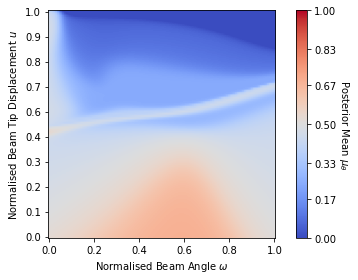

In [12]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'mean', phi_ticks_dp=2)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'reverse_kl_mean.pdf'), bbox_inches='tight')
plt.show()

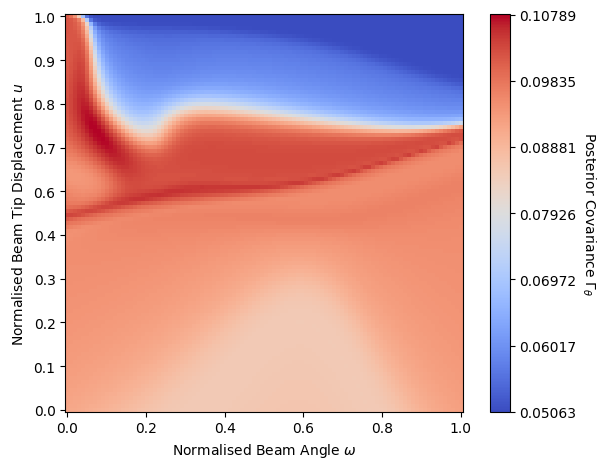

In [13]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(reverse_approx, y_lims, d_lims, num_y_pts, num_d_pts,
                                          'log_chol_diag', phi_ticks_dp=5)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'reverse_kl_variance.pdf'), bbox_inches='tight')
plt.show()

Let's also plot the loss history:

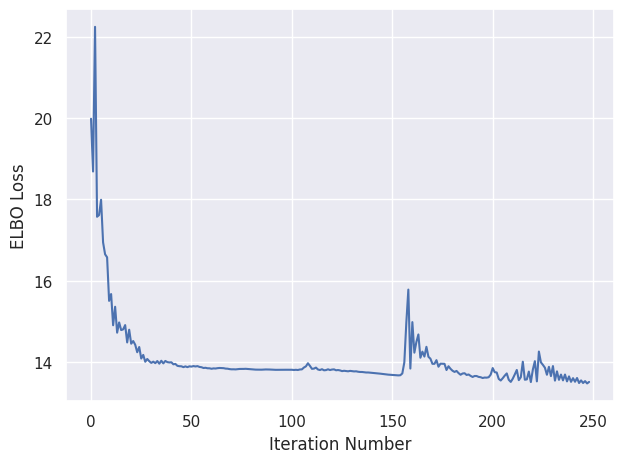

In [10]:
sns.set_theme(style='darkgrid')
fig = plotting_helpers.plot_loss_history(reverse_loss, y_label='ELBO Loss')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'reverse_kl_loss.pdf'), bbox_inches='tight')
plt.show()

## Forward KL Training

In [11]:
max_iter = 250
num_samples = 1000
y_lims = (0.0, 1.0)
d_lims = (0.0, 1.0)
num_y_pts = num_d_pts = 10
num_layers = 5
nn_width = 10
activation = 'tanh'
phi_lims = {'mean': {'lb':-0.25, 'ub':1.25}, 'log_chol_diag': {'lb':-3, 'ub':-2.}}
t_start = time.time()
forward_approx, forward_loss = \
computation_helpers.train_nn_amortised_normal_approx(beam_gp, y_lims, d_lims, num_y_pts, num_d_pts, 
                                                     noise_cov, prior_mean, prior_cov, 
                                                     jax_rng, num_samples, max_iter,
                                                     num_layers, nn_width, activation, phi_lims,
                                                     loss_name='forward_kl', use_reparameterisation=False,
                                                     verbose=True)
t_forward_train = time.time() - t_start
print(f'Took {t_forward_train:.2f} seconds to train Forward KL amortised approximation.')

Loss = 0.0014974591322243214, Params = Jaxtainer({'W_0': DeviceArray([[-0.6536162 ,  0.3022828 , -0.06648555, -0.7732551 ,
              -0.4575459 ,  1.8651717 ,  2.029333  , -0.48121464,
              -0.60303825,  0.22247635],
             [-0.19696456,  0.3423713 ,  0.5620768 , -1.055193  ,
               0.6148088 , -1.64818   ,  0.03363144,  0.820117  ,
              -0.5448918 ,  0.3766386 ]], dtype=float32), 'b_0': DeviceArray([ 0.09999908,  0.09999784,  0.09999956,  0.09999528,
             -0.09999872, -0.09999529,  0.09999689, -0.09999961,
             -0.09999835,  0.09999948], dtype=float32), 'W_1': DeviceArray([[-0.3503365 ,  0.35684502, -0.492828  ,  0.66309303,
               0.07340991, -0.11211782,  0.07851107,  0.27573383,
               0.10759655,  0.24840575],
             [ 0.08082427,  0.49392077,  0.26362556,  0.7210415 ,
              -0.2866511 ,  0.19135097,  0.29292065,  0.4357772 ,
              -0.22528657,  0.4752691 ],
             [-0.73150814, -0.5640

Saving these trained weights:

In [16]:
# forward_approx.save('forward_kl_approx')
forward_approx = computation_helpers.load_approx_post('forward_kl_approx.json', activation, num_layers, nn_width, phi_lims)

Once again, let's plot the mean and variance surfaces:

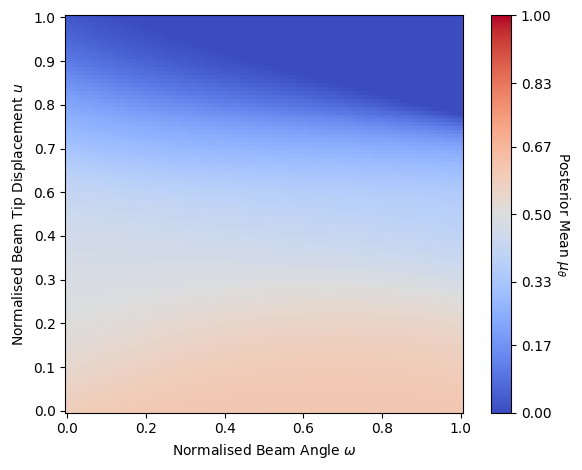

In [17]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(forward_approx, y_lims, d_lims, num_y_pts, num_d_pts, 'mean', phi_ticks_dp=2)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'forward_kl_mean.pdf'), bbox_inches='tight')
plt.show()

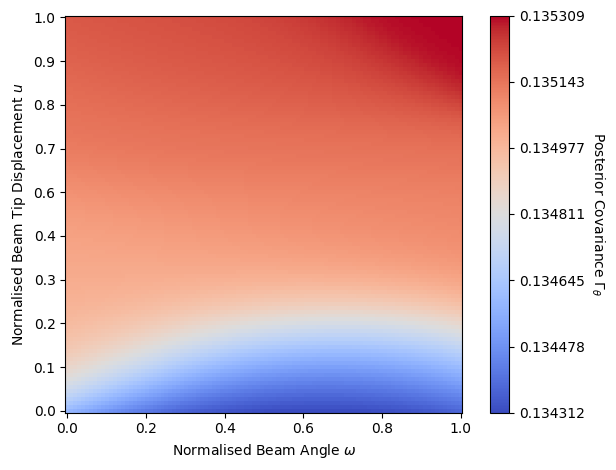

In [18]:
num_y_pts = num_d_pts = 100
mpl.rcParams.update(mpl.rcParamsDefault)
fig = plotting_helpers.plot_amortised_phi(forward_approx, y_lims, d_lims, num_y_pts, num_d_pts, 
                                          'log_chol_diag', phi_ticks_dp=6)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'forward_kl_variance.pdf'), bbox_inches='tight')
plt.show()

Plotting the loss history:

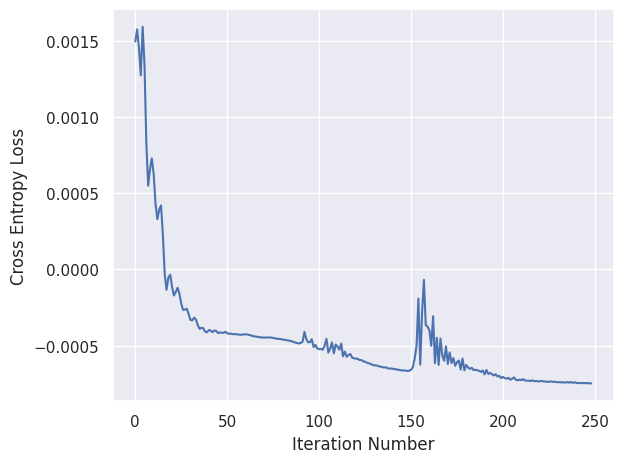

In [15]:
sns.set_theme(style='darkgrid')
fig = plotting_helpers.plot_loss_history(forward_loss, y_label='Cross Entropy Loss')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'forward_kl_loss.pdf'), bbox_inches='tight')
plt.show()